# Data Preprocessing for 0.5m Resolution Data

This notebook handles preprocessing and verification of the 0.5m resolution dataset.

**Dataset**: 0.5m resolution aerial imagery
- Pre-tiled 512×512 pixel tiles
- Stored as memory-mapped numpy arrays (.npy)
- 5 land cover classes: Background, Building, Woodland, Water, Road

**Steps**:
1. Load and verify the preprocessed data
2. Explore data statistics
3. Analyze class distribution
4. Visualize samples
5. Create train/val split (if needed)
6. Calculate class weights for training

## 1. Setup and Configuration

In [ ]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

# Configuration
DATA_ROOT = Path('../data')
DATA_05M_DIR = DATA_ROOT / '0_5m'

PLOTS_DIR = Path('../plots/0_5m')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# File paths
IMAGES_FILE = DATA_05M_DIR / '512dataset_images.npy'
LABELS_FILE = DATA_05M_DIR / '512dataset_labels.npy'

# Class definitions (binary)
CLASS_NAMES = ['not_mangrove', 'mangrove']
NUM_CLASSES = 2
IGNORE_INDEX = 255  # No-data/ignore value

CLASS_COLORS = {
    0: [0.8, 0.8, 0.8],    # Not mangrove - gray
    1: [0.0, 0.8, 0.0],    # Mangrove - green
}
print(f"Data directory: {DATA_05M_DIR.absolute()}")
print(f"Images file: {IMAGES_FILE}")
print(f"Labels file: {LABELS_FILE}")

Data directory: c:\vscode workspace\ml-mangrove\DroneClassification\human_infra\01_data_preprocessing\..\data\0_5m
Images file: ..\data\0_5m\512dataset_images.npy
Labels file: ..\data\0_5m\512dataset_labels.npy


## 2. Load and Verify Data

In [2]:
# Check if files exist
print("=== Checking Data Files ===")
print()

if not IMAGES_FILE.exists():
    raise FileNotFoundError(f"Images file not found: {IMAGES_FILE}")
if not LABELS_FILE.exists():
    raise FileNotFoundError(f"Labels file not found: {LABELS_FILE}")

print(f"✓ Images file exists: {IMAGES_FILE.stat().st_size / 1024**2:.1f} MB")
print(f"✓ Labels file exists: {LABELS_FILE.stat().st_size / 1024**2:.1f} MB")

=== Checking Data Files ===

✓ Images file exists: 429.8 MB
✓ Labels file exists: 143.3 MB


In [3]:
# Load data as memory-mapped arrays (efficient for large datasets)
print("\n=== Loading Data (memory-mapped) ===")
print()

images = np.load(IMAGES_FILE, mmap_mode='r')
labels = np.load(LABELS_FILE, mmap_mode='r')

print(f"Images:")
print(f"  Shape: {images.shape}")
print(f"  Dtype: {images.dtype}")
print(f"  Memory: {images.nbytes / 1024**2:.1f} MB (if loaded)")
print()
print(f"Labels:")
print(f"  Shape: {labels.shape}")
print(f"  Dtype: {labels.dtype}")
print(f"  Memory: {labels.nbytes / 1024**2:.1f} MB (if loaded)")
print()
print(f"Total samples: {len(images):,}")


=== Loading Data (memory-mapped) ===

Images:
  Shape: (573, 3, 512, 512)
  Dtype: uint8
  Memory: 429.8 MB (if loaded)

Labels:
  Shape: (573, 1, 512, 512)
  Dtype: uint8
  Memory: 143.2 MB (if loaded)

Total samples: 573


In [4]:
# Verify data format
print("=== Verifying Data Format ===")
print()

# Check a sample image
sample_img = images[0]
sample_lbl = labels[0]

print(f"Sample image shape: {sample_img.shape}")
print(f"Sample label shape: {sample_lbl.shape}")
print()

# Determine format
if sample_img.shape[0] == 3:
    print("Image format: CHW (Channel, Height, Width)")
    img_h, img_w = sample_img.shape[1], sample_img.shape[2]
elif sample_img.shape[-1] == 3:
    print("Image format: HWC (Height, Width, Channel)")
    img_h, img_w = sample_img.shape[0], sample_img.shape[1]
else:
    print(f"Unknown image format: {sample_img.shape}")
    img_h, img_w = None, None

print(f"Tile size: {img_h}×{img_w}")
print()

# Check value ranges
print(f"Image value range: [{sample_img.min()}, {sample_img.max()}]")
print(f"Label unique values (first 10 samples): {np.unique(labels[:10])}")

=== Verifying Data Format ===

Sample image shape: (3, 512, 512)
Sample label shape: (1, 512, 512)

Image format: CHW (Channel, Height, Width)
Tile size: 512×512

Image value range: [0, 255]
Label unique values (first 10 samples): [  0   1 255]


## 3. Data Statistics

In [5]:
# Compute statistics on a sample of images
print("=== Computing Image Statistics ===")
print()

SAMPLE_SIZE = min(1000, len(images))
sample_indices = np.random.choice(len(images), SAMPLE_SIZE, replace=False)

# Collect statistics
means = []
stds = []

for idx in tqdm(sample_indices, desc="Computing stats"):
    img = images[idx].astype(np.float32)
    
    # Normalize to 0-1 if needed
    if img.max() > 1:
        img = img / 255.0
    
    # Handle CHW vs HWC
    if img.shape[0] == 3:
        means.append(img.mean(axis=(1, 2)))
        stds.append(img.std(axis=(1, 2)))
    else:
        means.append(img.mean(axis=(0, 1)))
        stds.append(img.std(axis=(0, 1)))

means = np.array(means)
stds = np.array(stds)

print(f"\nDataset Statistics (from {SAMPLE_SIZE} samples):")
print(f"  Mean (RGB): [{means[:, 0].mean():.4f}, {means[:, 1].mean():.4f}, {means[:, 2].mean():.4f}]")
print(f"  Std (RGB):  [{stds[:, 0].mean():.4f}, {stds[:, 1].mean():.4f}, {stds[:, 2].mean():.4f}]")
print()
print("  ImageNet stats for reference:")
print(f"    Mean: [0.485, 0.456, 0.406]")
print(f"    Std:  [0.229, 0.224, 0.225]")

=== Computing Image Statistics ===



Computing stats: 100%|██████████| 573/573 [00:02<00:00, 259.59it/s]


Dataset Statistics (from 573 samples):
  Mean (RGB): [0.6228, 0.6260, 0.5293]
  Std (RGB):  [0.1991, 0.1866, 0.2059]

  ImageNet stats for reference:
    Mean: [0.485, 0.456, 0.406]
    Std:  [0.229, 0.224, 0.225]


## 4. Analyze Class Distribution

In [6]:
# Analyze class distribution
print("=== Analyzing Class Distribution ===")
print()

# Count pixels per class (excluding ignore value)
class_counts = {i: 0 for i in range(NUM_CLASSES)}
ignore_count = 0
total_pixels = 0

for idx in tqdm(range(len(labels)), desc="Counting classes"):
    lbl = labels[idx]
    if lbl.ndim == 3:
        lbl = lbl.squeeze()
    
    for class_id in range(NUM_CLASSES):
        class_counts[class_id] += (lbl == class_id).sum()
    ignore_count += (lbl == IGNORE_INDEX).sum()
    total_pixels += lbl.size

valid_pixels = total_pixels - ignore_count

print(f"\nAnalyzed {len(labels)} samples ({total_pixels:,} total pixels)")
print(f"Ignore pixels (255): {ignore_count:,} ({ignore_count/total_pixels*100:.1f}%)")
print(f"Valid pixels: {valid_pixels:,}")
print()
print("Class Distribution (excluding ignore):")
print("-" * 50)

class_frequencies = {}
for class_id in range(NUM_CLASSES):
    count = class_counts[class_id]
    pct = (count / valid_pixels * 100) if valid_pixels > 0 else 0
    class_frequencies[class_id] = count / valid_pixels if valid_pixels > 0 else 0
    print(f"  {class_id} ({CLASS_NAMES[class_id]:12s}): {count:>12,} pixels ({pct:>5.2f}%)")

=== Analyzing Class Distribution ===



Counting classes: 100%|██████████| 573/573 [00:00<00:00, 1815.39it/s]


Analyzed 573 samples (150,208,512 total pixels)
Ignore pixels (255): 41,082,738 (27.4%)
Valid pixels: 109,125,774

Class Distribution (excluding ignore):
--------------------------------------------------
  0 (not_mangrove):   68,394,240 pixels (62.67%)
  1 (mangrove    ):   40,731,534 pixels (37.33%)


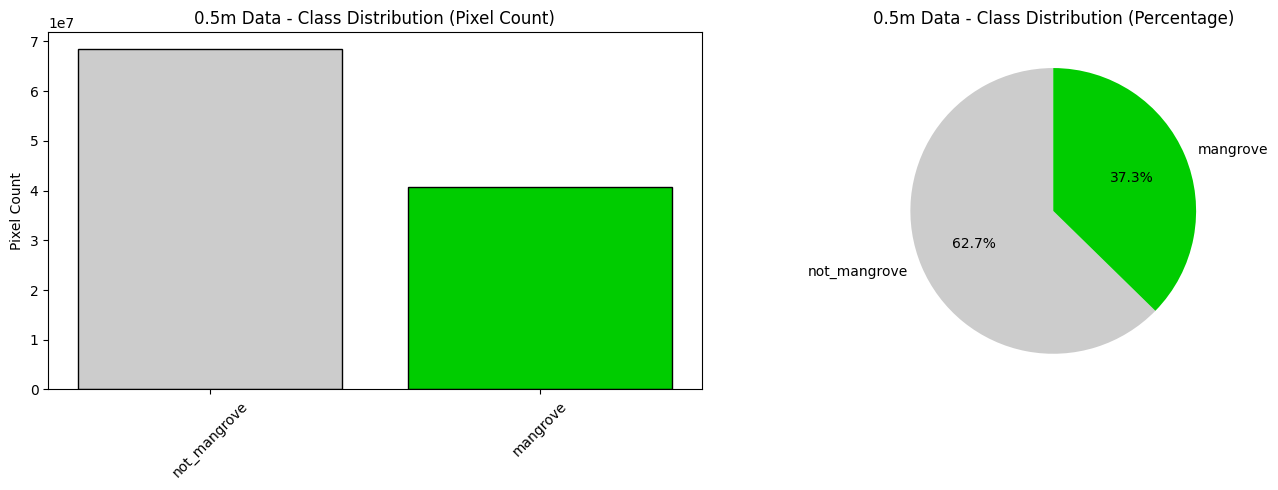

✓ Saved class_distribution.png


In [ ]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = [CLASS_COLORS[i] for i in range(NUM_CLASSES)]
counts = [class_counts[i] for i in range(NUM_CLASSES)]
axes[0].bar(CLASS_NAMES, counts, color=colors, edgecolor='black')
axes[0].set_ylabel('Pixel Count')
axes[0].set_title('0.5m Data - Class Distribution (Pixel Count)')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(counts, labels=CLASS_NAMES, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1].set_title('0.5m Data - Class Distribution (Percentage)')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Saved class_distribution.png")

## 5. Visualize Samples

=== Visualizing Random Samples ===



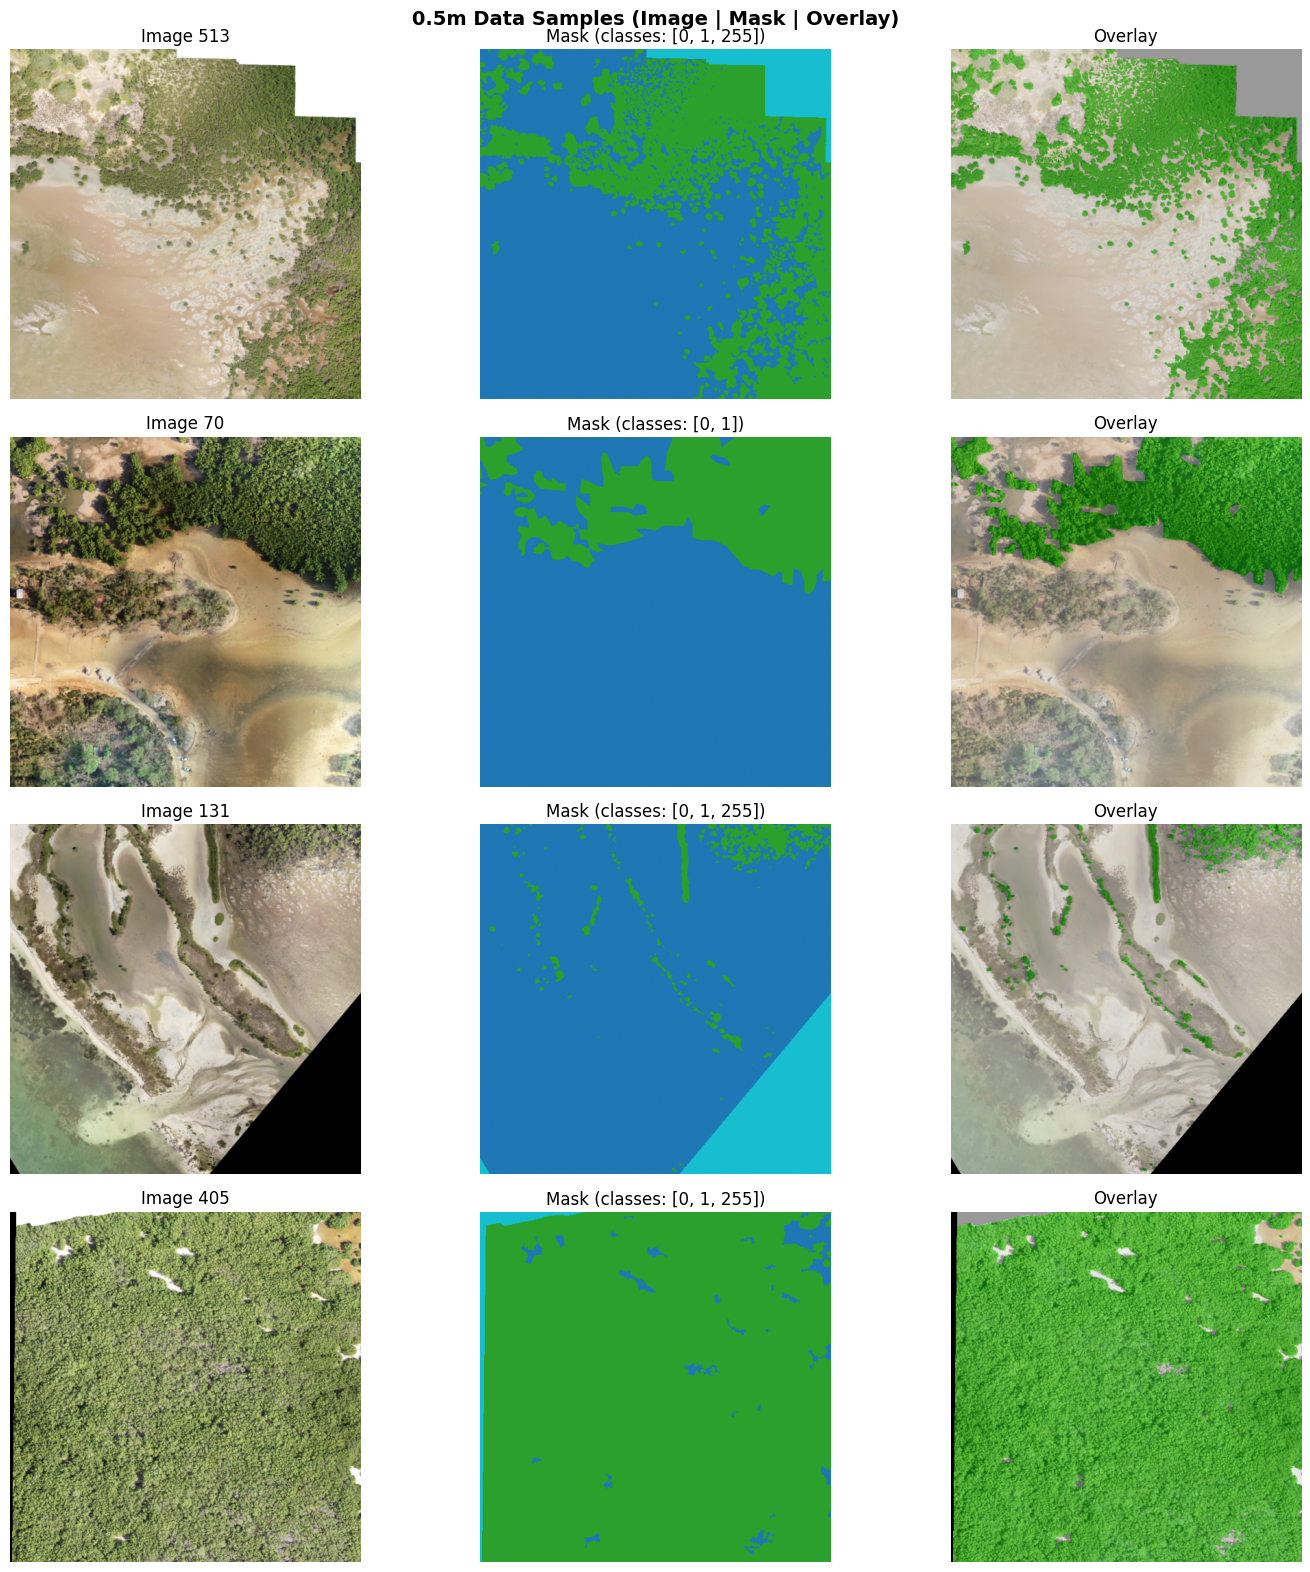

✓ Saved sample_tiles.png


In [ ]:
# Visualize random samples
print("=== Visualizing Random Samples ===")
print()

np.random.seed(42)
sample_indices = np.random.choice(len(images), 4, replace=False)

fig, axes = plt.subplots(4, 3, figsize=(15, 16))
fig.suptitle('0.5m Data Samples (Image | Mask | Overlay)', fontsize=14, fontweight='bold')

for row, idx in enumerate(sample_indices):
    img = images[idx]
    lbl = labels[idx]
    
    # Handle CHW format
    if img.shape[0] == 3:
        img = img.transpose(1, 2, 0)
    if lbl.ndim == 3:
        lbl = lbl.squeeze()
    
    # Normalize image for display
    img_display = img.astype(np.float32)
    if img_display.max() > 1:
        img_display = img_display / 255.0
    
    # Image
    axes[row, 0].imshow(img_display)
    axes[row, 0].set_title(f'Image {idx}')
    axes[row, 0].axis('off')
    
    # Mask
    axes[row, 1].imshow(lbl, cmap='tab10', vmin=0, vmax=5)
    axes[row, 1].set_title(f'Mask (classes: {np.unique(lbl).tolist()})')
    axes[row, 1].axis('off')
    
    # Overlay
    mask_rgb = np.zeros((*lbl.shape, 3))
    for class_id, color in CLASS_COLORS.items():
        mask_rgb[lbl == class_id] = color
    overlay = 0.6 * img_display + 0.4 * mask_rgb
    axes[row, 2].imshow(np.clip(overlay, 0, 1))
    axes[row, 2].set_title('Overlay')
    axes[row, 2].axis('off')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'sample_tiles.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Saved sample_tiles.png")

In [9]:
# Visualize samples for each class
print("=== Finding Samples for Each Class ===")
print()

# Find samples that contain each class prominently
class_samples = {i: [] for i in range(NUM_CLASSES)}

for idx in tqdm(range(min(5000, len(labels))), desc="Finding class samples"):
    lbl = labels[idx]
    if lbl.ndim == 3:
        lbl = lbl.squeeze()
    
    for class_id in range(NUM_CLASSES):
        if len(class_samples[class_id]) < 2:  # Find 2 samples per class
            class_pct = (lbl == class_id).sum() / lbl.size
            if class_pct > 0.1:  # At least 10% of the tile is this class
                class_samples[class_id].append(idx)

print("\nSamples found per class:")
for class_id, samples in class_samples.items():
    print(f"  {CLASS_NAMES[class_id]}: {len(samples)} samples (indices: {samples})")

=== Finding Samples for Each Class ===



Finding class samples: 100%|██████████| 573/573 [00:00<00:00, 190922.80it/s]


Samples found per class:
  not_mangrove: 2 samples (indices: [0, 1])
  mangrove: 2 samples (indices: [0, 2])


## 6. Calculate Class Weights

In [10]:
import torch

print("=== Calculating Class Weights ===")
print()

# Convert frequencies to tensor
freq_tensor = torch.tensor([class_frequencies[i] for i in range(NUM_CLASSES)])

# Handle zero frequencies
freq_tensor = torch.clamp(freq_tensor, min=1e-6)

# Method 1: Inverse frequency
weights_inv = 1.0 / freq_tensor
weights_inv = weights_inv / weights_inv.sum()  # Normalize

# Method 2: Inverse square root (recommended - less aggressive)
weights_sqrt = 1.0 / torch.sqrt(freq_tensor)
weights_sqrt = weights_sqrt / weights_sqrt.mean()  # Normalize to mean=1

# Method 3: Log inverse (even less aggressive)
weights_log = torch.log(1.0 / freq_tensor + 1)
weights_log = weights_log / weights_log.mean()

print("Class Frequencies:")
print(f"  {[f'{f:.4f}' for f in freq_tensor.tolist()]}")
print()
print("Weight Options:")
print(f"  Inverse frequency:          {[f'{w:.4f}' for w in weights_inv.tolist()]}")
print(f"  Inverse sqrt (recommended): {[f'{w:.4f}' for w in weights_sqrt.tolist()]}")
print(f"  Log inverse:                {[f'{w:.4f}' for w in weights_log.tolist()]}")

=== Calculating Class Weights ===

Class Frequencies:
  ['0.6267', '0.3733']

Weight Options:
  Inverse frequency:          ['0.3733', '0.6267']
  Inverse sqrt (recommended): ['0.8711', '1.1289']
  Log inverse:                ['0.8454', '1.1546']


In [11]:
# Save class weights
weights_dict = {
    'class_names': CLASS_NAMES,
    'class_frequencies': freq_tensor.tolist(),
    'weights_inverse_sqrt': weights_sqrt.tolist(),
    'weights_inverse': weights_inv.tolist(),
    'weights_log': weights_log.tolist(),
    'total_pixels_sampled': total_pixels,
    'num_samples_analyzed': SAMPLE_SIZE
}

weights_file = DATA_05M_DIR / 'class_weights.json'
with open(weights_file, 'w') as f:
    json.dump(weights_dict, f, indent=2)

print(f"✓ Saved {weights_file}")
print()
print("To use in training:")
print("```python")
print("import json")
print(f"with open('{weights_file.name}') as f:")
print("    weights_dict = json.load(f)")
print("class_weights = torch.tensor(weights_dict['weights_inverse_sqrt']).to(device)")
print("```")

✓ Saved ..\data\0_5m\class_weights.json

To use in training:
```python
import json
with open('class_weights.json') as f:
    weights_dict = json.load(f)
class_weights = torch.tensor(weights_dict['weights_inverse_sqrt']).to(device)
```


## 7. Create Train/Val Split (Optional)

If your data isn't already split, you can create a train/validation split here.

In [12]:
# Check if split files already exist
train_split_file = DATA_05M_DIR / 'train_indices.npy'
val_split_file = DATA_05M_DIR / 'val_indices.npy'

if train_split_file.exists() and val_split_file.exists():
    print("Split files already exist:")
    train_indices = np.load(train_split_file)
    val_indices = np.load(val_split_file)
    print(f"  Train: {len(train_indices):,} samples")
    print(f"  Val: {len(val_indices):,} samples")
    CREATE_SPLIT = False
else:
    print("No split files found. Will create new split.")
    CREATE_SPLIT = True

No split files found. Will create new split.


In [13]:
# Create train/val split if needed
if CREATE_SPLIT:
    TRAIN_RATIO = 0.8
    
    n_samples = len(images)
    indices = np.arange(n_samples)
    np.random.seed(42)  # For reproducibility
    np.random.shuffle(indices)
    
    split_idx = int(n_samples * TRAIN_RATIO)
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]
    
    # Save split
    np.save(train_split_file, train_indices)
    np.save(val_split_file, val_indices)
    
    print(f"Created {TRAIN_RATIO*100:.0f}/{(1-TRAIN_RATIO)*100:.0f} train/val split:")
    print(f"  Train: {len(train_indices):,} samples")
    print(f"  Val: {len(val_indices):,} samples")
    print()
    print(f"✓ Saved {train_split_file.name}")
    print(f"✓ Saved {val_split_file.name}")
else:
    print("Using existing split files.")

Created 80/20 train/val split:
  Train: 458 samples
  Val: 115 samples

✓ Saved train_indices.npy
✓ Saved val_indices.npy


## 8. Test Data Loading with MemmapDataset

In [14]:
# Test loading with the repo's MemmapDataset class
sys.path.insert(0, '../../..')

try:
    from DroneClassification.data.MemoryMapDataset import MemmapDataset
    
    print("=== Testing MemmapDataset ===")
    print()
    
    dataset = MemmapDataset(
        images=str(IMAGES_FILE),
        labels=str(LABELS_FILE)
    )
    
    print(f"Dataset loaded: {len(dataset)} samples")
    
    # Test getting an item
    img, lbl = dataset[0]
    print(f"Sample image: {img.shape}, dtype={img.dtype}")
    print(f"Sample label: {lbl.shape}, dtype={lbl.dtype}")
    print()
    print("✓ MemmapDataset working correctly!")
    
except ImportError as e:
    print(f"Could not import MemmapDataset: {e}")
    print("This is optional - you can use a custom Dataset class instead.")

=== Testing MemmapDataset ===

Dataset loaded: 573 samples
Sample image: torch.Size([3, 512, 512]), dtype=torch.float32
Sample label: torch.Size([1, 512, 512]), dtype=torch.int64

✓ MemmapDataset working correctly!


## 9. Summary

In [15]:
print("="*60)
print("0.5m Data Preprocessing Summary")
print("="*60)
print()
print(f"Dataset: 0.5m Resolution")
print(f"Location: {DATA_05M_DIR}")
print()
print(f"Data Files:")
print(f"  Images: {IMAGES_FILE.name} ({images.shape})")
print(f"  Labels: {LABELS_FILE.name} ({labels.shape})")
print()
print(f"Total Samples: {len(images):,}")
print(f"Tile Size: 512×512")
print(f"Classes: {CLASS_NAMES}")
print()
print("Output Files:")
print(f"  - class_distribution.png")
print(f"  - sample_tiles.png")
print(f"  - class_weights.json")
if CREATE_SPLIT:
    print(f"  - train_indices.npy ({len(train_indices):,} samples)")
    print(f"  - val_indices.npy ({len(val_indices):,} samples)")
print()
print("✓ Preprocessing complete!")
print()
print("Next: Use the training notebook at 03_model_training/")

0.5m Data Preprocessing Summary

Dataset: 0.5m Resolution
Location: ..\data\0_5m

Data Files:
  Images: 512dataset_images.npy ((573, 3, 512, 512))
  Labels: 512dataset_labels.npy ((573, 1, 512, 512))

Total Samples: 573
Tile Size: 512×512
Classes: ['not_mangrove', 'mangrove']

Output Files:
  - class_distribution.png
  - sample_tiles.png
  - class_weights.json
  - train_indices.npy (458 samples)
  - val_indices.npy (115 samples)

✓ Preprocessing complete!

Next: Use the training notebook at 03_model_training/
